In [1]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
series = read_csv('C:/Users/User/Documents/Files/transections.csv', header=0, index_col=0, parse_dates=True)
#series = series.drop(['voucher_type','voucher_number','party_name','mailing_pincode','mailing_state','branch_name','item'],axis=1)

In [4]:
series

,amount
date,
2020-05-21 05:51:59.453,9900.0
2020-05-21 06:08:46.968,10500.0
2020-05-21 06:14:41.335,15500.0
2020-05-21 06:24:30.536,50500.0
2020-05-21 11:22:34.049,25500.0
...,...
2025-01-01 22:36:19.514,3361.0
2025-01-01 22:59:40.066,3464.0
2025-01-01 23:00:08.076,3420.0


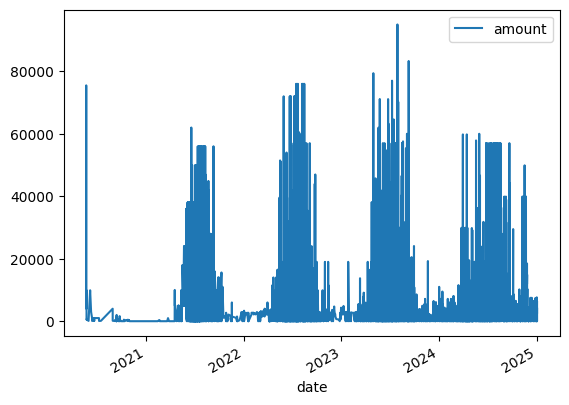

In [5]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
series.plot()
pyplot.show()

array([[<Axes: title={'center': 'amount'}>]], dtype=object)

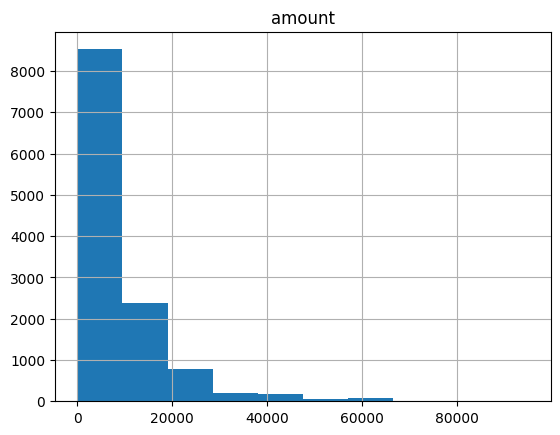

In [6]:
series.hist()

<Axes: ylabel='Density'>

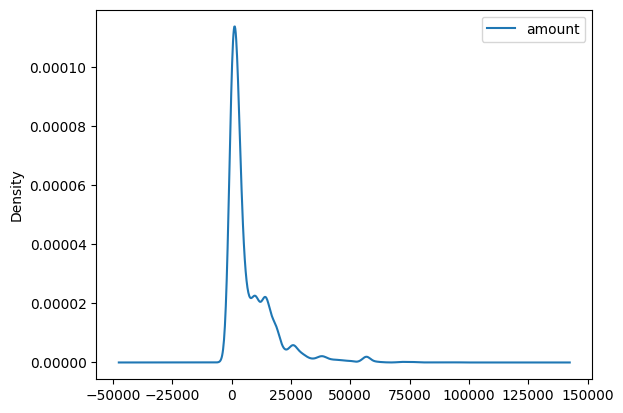

In [7]:
series.plot(kind='kde')

In [9]:
# separate out a validation dataset
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 12203, Validation 10


#### Persistence/ Base model

In [10]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]


In [12]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=1500.000, Expected=15641.000
>Predicted=15641.000, Expected=1500.000
>Predicted=1500.000, Expected=1500.000
>Predicted=1500.000, Expected=0.000
>Predicted=0.000, Expected=3861.000
>Predicted=3861.000, Expected=3850.000
>Predicted=3850.000, Expected=500.000
>Predicted=500.000, Expected=1500.000
>Predicted=1500.000, Expected=500.000
>Predicted=500.000, Expected=700.000
>Predicted=700.000, Expected=500.000
>Predicted=500.000, Expected=600.000
>Predicted=600.000, Expected=500.000
>Predicted=500.000, Expected=500.000
>Predicted=500.000, Expected=1500.000
>Predicted=1500.000, Expected=0.000
>Predicted=0.000, Expected=19250.000
>Predicted=19250.000, Expected=500.000
>Predicted=500.000, Expected=500.000
>Predicted=500.000, Expected=500.000
>Predicted=500.000, Expected=800.000
>Predicted=800.000, Expected=300.000
>Predicted=300.000, Expected=500.000
>Predicted=500.000, Expected=500.000
>Predicted=500.000, Expected=500.000
>Predicted=500.000, Expected=6772.000
>Predicted=6772.000, Exp

C:\Users\User\AppData\Local\Temp\ipykernel_18316\1970986772.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))


#### ARIMA Hyperparameters

In [19]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse  

#### Grid search for p,d,q values

In [20]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [21]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True)
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


#### Build Model based on the optimized values

In [22]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [23]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')


In [24]:
# fit model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.predict(1, 79)

array([6.11254965e+03, 9.82769678e+03, 2.51915399e+04, 2.54107218e+04,
       2.28408182e+04, 4.81651762e+04, 2.71249052e+04, 2.30592741e+04,
       2.45020460e+04, 1.05000000e+04, 2.64070961e+04, 1.82739972e+04,
       1.72071837e+04, 1.60992816e+04, 8.53154954e+03, 4.84552699e+03,
       3.40559302e+03, 2.76499410e+03, 5.47551963e+02, 4.94878236e+02,
       4.10494658e+03, 3.21635236e+03, 2.86741929e+03, 2.93247639e+03,
       9.00592489e+02, 2.97880785e+02, 4.61641490e+02, 2.88568678e+02,
       6.27845085e+02, 8.33933641e+02, 8.08279678e+02, 6.34136790e+02,
       4.61777228e+02, 1.84308767e+03, 9.24519351e+02, 8.66815621e+02,
       9.50696318e+02, 1.04393888e+02, 1.99490056e+02, 9.72285722e+01,
       1.01703535e+02, 9.07967892e+01, 9.32957071e+00, 1.07708046e+01,
       1.59070961e+02, 8.01260367e+01, 7.46365657e+01, 5.63379319e+02,
       3.59681331e+02, 4.03307445e+02, 4.93874483e+02, 9.76051583e+02,
       5.21232435e+02, 4.37807656e+02, 5.50135405e+02, 7.99783976e+01,
      

In [26]:
#Error on the test data
#val=pd.read_csv('validation.csv',header=None)
#rmse = sqrt(mean_squared_error(val[1], forecast))
#rmse

#### Combine train and test data and build final model

In [35]:
# fit model
data = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
#X = train.series
X = X.astype('float32')

In [36]:
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()

In [38]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.predict(1,80)

array([6.11254965e+03, 9.82769678e+03, 2.51915399e+04, 2.54107218e+04,
       2.28408182e+04, 4.81651762e+04, 2.71249052e+04, 2.30592741e+04,
       2.45020460e+04, 1.05000000e+04, 2.64070961e+04, 1.82739972e+04,
       1.72071837e+04, 1.60992816e+04, 8.53154954e+03, 4.84552699e+03,
       3.40559302e+03, 2.76499410e+03, 5.47551963e+02, 4.94878236e+02,
       4.10494658e+03, 3.21635236e+03, 2.86741929e+03, 2.93247639e+03,
       9.00592489e+02, 2.97880785e+02, 4.61641490e+02, 2.88568678e+02,
       6.27845085e+02, 8.33933641e+02, 8.08279678e+02, 6.34136790e+02,
       4.61777228e+02, 1.84308767e+03, 9.24519351e+02, 8.66815621e+02,
       9.50696318e+02, 1.04393888e+02, 1.99490056e+02, 9.72285722e+01,
       1.01703535e+02, 9.07967892e+01, 9.32957071e+00, 1.07708046e+01,
       1.59070961e+02, 8.01260367e+01, 7.46365657e+01, 5.63379319e+02,
       3.59681331e+02, 4.03307445e+02, 4.93874483e+02, 9.76051583e+02,
       5.21232435e+02, 4.37807656e+02, 5.50135405e+02, 7.99783976e+01,
      

In [39]:
forecast

np.float64(2852.827358422127)